# Exploratory Data Analysis

# Intro

This notebook is for exploratory data analysis of the data provided in the OTTO – Multi-Objective Recommender System project. In this notebook, we will be understanding the properties of the dataset. After understanding the data, in other notebooks we will be benchmarking various machine learning approaches for building a recommendation system.

# Objective

The data description on the OTTO competition page on Kaggle mentions that for each `session`, we have the `ts` (time stamps), `aid` (article IDs), and `type` (event type). The `type` can be one of `clicks`, `carts`, and `orders`. The EDA in this notebook investigates the following in the training data:

1. Quantification: # of rows, counts of `session`, count of `aid`
2. Understanding User Behavior: count of unique `aid` per session (i.e. how many unique items the user is interested in), `clicks` per `session` (how much does the user browse), `carts` per `session` (how many items are added to cart), `orders` per `session` (are there multiple orders in a single session)
3. Understanding Articles: `clicks` per `aid` (i.e. most to least clicked articles), `carts` per `aid` (which items are added to cart the most), `orders` per `aid` (are there specific articles which trigger the ordering), co-occurence of `aid` (how likely are two `aid` to co-occur in a session), transition matrix of `aid` (which article will be clicked on next)
5. Understanding Time Spent: calculate difference of last and first `ts` as time elapsed, time elapsed per `session` (how much tiime does a user spend per session), time elapsed per `aid` (how much time is spent per article), time elapsed on an `aid` right before `carts` (how much time is spent on an article before adding to cart), time elapsed on `aid` added to cart and those `aid` not added to cart

Note: The training data set is very large (~13M sessions and ~217M events). Analyzing such large data for exploratory analysis only using the resources available on Kaggle would be quite challening. Therefore, we are using sample size of 150K. Techniques for performing exploratory data analyis on large datasets includes using the `multiprocessing` or `dask` packages. Another alternative would be, `pyspark`.

Note: As we proceed through the exploratory analysis in this notebook, our findings are summarized for each objective in cells beginning with **Findings**.

# References

1. https://www.kaggle.com/code/edwardcrookenden/otto-getting-started-eda-baseline
2. https://www.kaggle.com/code/inversion/read-a-chunk-of-jsonl
3. https://stackoverflow.com/questions/35562789/how-do-i-calculate-a-word-word-co-occurrence-matrix-with-sklearn
4. https://stackoverflow.com/a/49819594
5. https://developer.nvidia.com/blog/build-efficient-recommender-systems-with-co-visitation-matrices-and-rapids-cudf/
6. https://colab.research.google.com/drive/1CKxPGGjfdR7YUZ3BkATTMGZFV8Vjerwy?usp=sharing#scrollTo=0gI5U82Zh30a

# Virtual Env Freezing

#### Freezing the virtual environment on Kaggle
By documenting our environment, we want to ensures reproduceability.

In [1]:
!pip freeze > requirements.txt

# Reading Data

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
from datetime import timedelta

import os

from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import triu

# Apply the default theme
sns.set_theme()

data_path = r"/kaggle/input/otto-recommender-system/"

In [3]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [4]:
# Load in a sample to a pandas df

sample_size = 150000

chunks = pd.read_json(data_path+'/train.jsonl', lines=True, chunksize = sample_size)

for c in chunks:
    sample_train_df = c
    break

In [5]:
sample_train_df.head(3)

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."


In [6]:
sample_train_df.loc[0, "events"][0:3]

[{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'},
 {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'},
 {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'}]

In [7]:
# Expand the 'events' column into individual rows
expanded_df = sample_train_df.explode('events').reset_index(drop=True)
expanded_df.head(3)

,session,events
0,0,"{'aid': 1517085, 'ts': 1659304800025, 'type': ..."
1,0,"{'aid': 1563459, 'ts': 1659304904511, 'type': ..."
2,0,"{'aid': 1309446, 'ts': 1659367439426, 'type': ..."


In [8]:
# Convert the dictionaries in 'events' column into separate columns
expanded_df[["aid", "ts", "type"]] = pd.json_normalize(expanded_df['events'])
expanded_df = expanded_df.drop('events', axis=1)
expanded_df.head(3)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks


In [9]:
expanded_df.shape

(7841827, 4)

# Quantification

### # of rows

In [10]:
# %%time 

# num_lines = sum(1 for line in open(data_path+'/train.jsonl'))
# print(f'number of lines in train: {num_lines:,}')

In [11]:
print(f'number of sessions in the sample of training data: {len(expanded_df["session"].unique()):,}')

number of sessions in the sample of training data: 150,000


In [12]:
print(f'number of aid in the sample of training data: {len(expanded_df["aid"].unique()):,}')

number of aid in the sample of training data: 830,140


# Understanding User Behavior

### Count of unique aid per session

How many unique items the user is interested in?

In [13]:
naid_per_session = (
    expanded_df
    .groupby(["session"])
    ["aid"]
    .nunique()
    .reset_index()
)

In [14]:
naid_per_session["aid"].min(), naid_per_session["aid"].max()

(1, 460)

In [15]:
naid_per_session["aid"].value_counts()[0:20]

aid
2     15381
3     10858
4      8256
5      6743
6      5704
1      5332
7      4869
8      4443
9      3838
10     3478
11     3172
12     2979
13     2792
14     2473
15     2344
16     2291
17     2075
18     1935
19     1768
20     1707
Name: count, dtype: int64

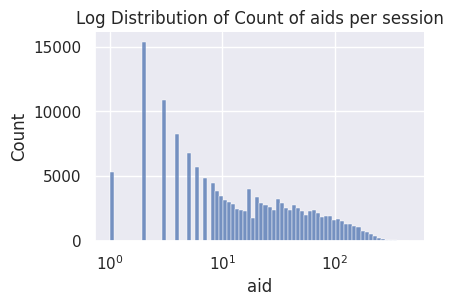

In [16]:
(
    sns.displot(data=naid_per_session, x='aid', log_scale=True, height=3, aspect=1.5)
    .set(
        title='Log Distribution of Count of aids per session',
    )
)

**Findings**
1. The least number of products looked at by the user is 1. The most is 460.
2. Most users look at 2 products, followed by 3, 4, 5 and 6 products. 
3. The next highest number of products viewed by the user is 1 product.

### Clicks per session

How much does the user browse?

In [17]:
nclicks_per_session = (
    expanded_df
    .loc[expanded_df["type"]=="clicks"]
    .groupby(["session"])
    ["type"]
    .count()
    .reset_index()
)

In [18]:
nclicks_per_session["type"].min(), nclicks_per_session["type"].max()

(2, 493)

In [19]:
nclicks_per_session["type"].value_counts()[0:20]

type
2     13509
3      9750
4      7612
5      6149
6      5194
7      4409
8      4167
9      3567
10     3235
11     2937
12     2641
13     2617
14     2460
15     2191
16     2115
17     1954
18     1811
20     1770
19     1759
21     1583
Name: count, dtype: int64

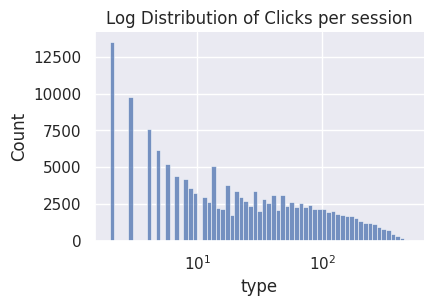

In [20]:
(
    sns.displot(data=nclicks_per_session, x='type', log_scale=True, height=3, aspect=1.5)
    .set(
        title='Log Distribution of Clicks per session',
    )
)

**Findings**:
1. Minimum number of clicks in a session is 2, maximum is 493.
2. Most user click at least twice.
3. The distrubtion is very similar to that of the number of articles.

### Carts per session 

How many items are added to cart?

In [21]:
ncarts_per_session = (
    expanded_df
    .loc[expanded_df["type"]=="carts"]
    .groupby(["session"])
    ["type"]
    .count()
    .reset_index()
)

In [22]:
ncarts_per_session.head(3)

,session,type
0,0,17
1,1,8
2,2,1


In [23]:
ncarts_per_session["type"].min(), ncarts_per_session["type"].max()

(1, 399)

In [24]:
ncarts_per_session["type"].value_counts()[0:20]

type
1     15668
2      9568
3      6759
4      5195
5      4167
6      3507
7      2861
8      2429
9      2110
10     1878
11     1579
12     1449
13     1216
14     1125
15      997
16      873
17      768
18      744
19      618
20      580
Name: count, dtype: int64

In [25]:
(
    ncarts_per_session["type"].value_counts()[0:3].sum()
    /
    ncarts_per_session["type"].value_counts()[4:].sum()
)

0.956216377764495

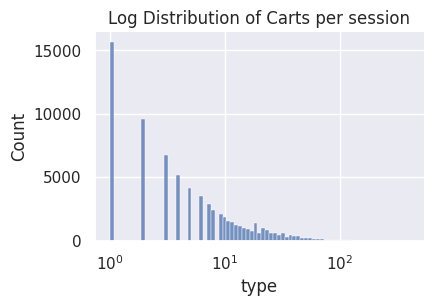

In [26]:
(
    sns.displot(data=ncarts_per_session, x='type', log_scale=True, height=3, aspect=1.5)
    .set(
        title='Log Distribution of Carts per session',
    )
)

**Findings**:
1. Most users add 1 article to card, followed by 2 and 3 articles.
2. The max number of items added to card are 399.
3. The number of users adding 1 and 2 or 3 articles to card is about the same as the users adding 4 or more articles to cart.

# Understanding Articles

`clicks` per `aid` (i.e. most to least clicked articles), `carts` per `aid` (which items are added to cart the most), `orders` per `aid` (are there specific articles which trigger the ordering), co-occurence of `aid` (how likely are two `aid` to co-occur in a session), transition matrix of `aid` (which article will be clicked on next)

### Clicks, Carts and Orders per `aid`

- Most to least clicked articles
- Which items are added to the cart most
- Are there specific articles which trigger the order

In [27]:
n_per_aid = (
    expanded_df
    .groupby(["aid","type"])
    ["session"]
    .count()
    .reset_index()
    .rename(columns={"session":"count"})
)

In [28]:
x = n_per_aid.loc[(n_per_aid["type"]=="clicks") & (n_per_aid["count"]>5), 'aid'].nunique()
y = n_per_aid.loc[(n_per_aid["type"]=="clicks"), 'aid'].nunique()
print(f"% of clicked articles with more than 5 clicks is :{x*100/y:.2f}%")

x = n_per_aid.loc[(n_per_aid["type"]=="carts") & (n_per_aid["count"]>5), 'aid'].nunique()
y = n_per_aid.loc[(n_per_aid["type"]=="carts"), 'aid'].nunique()
print(f"% of articles added to cart with more than 5 add to cart is :{x*100/y:.2f}%")

x = n_per_aid.loc[(n_per_aid["type"]=="orders") & (n_per_aid["count"]>3), 'aid'].nunique()
y = n_per_aid.loc[(n_per_aid["type"]=="orders"), 'aid'].nunique()
print(f"% of ordered articles with more than 3 orders is :{x*100/y:.2f}%")

% of clicked articles with more than 5 clicks is :25.64%
% of articles added to cart with more than 5 add to cart is :8.41%
% of ordered articles with more than 3 orders is :9.02%


In [29]:
x = n_per_aid.loc[(n_per_aid["type"]=="clicks"), 'aid'].nunique()
y = n_per_aid.loc[(n_per_aid["type"]=="carts"), 'aid'].nunique()
z = n_per_aid.loc[(n_per_aid["type"]=="orders"), 'aid'].nunique()

print(f"Conversion rate from clicks to carts is: {y*100/x:.2f}%")
print(f"Conversion rate from carts to orders is: {z*100/y:.2f}%")
print(f"Conversion rate from clicks to orders is: {z*100/x:.2f}%")

Conversion rate from clicks to carts is: 25.71%
Conversion rate from carts to orders is: 38.62%
Conversion rate from clicks to orders is: 9.93%


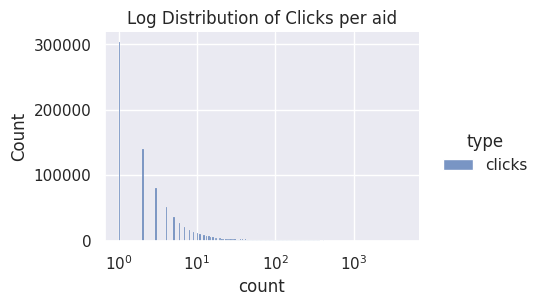

In [30]:
(
    sns.displot(
        data=n_per_aid.loc[n_per_aid["type"]=="clicks"], 
        x='count',
        hue='type',
        log_scale=True,
        multiple='dodge',
        height=3, 
        aspect=1.5,
    )
    .set(
        title='Log Distribution of Clicks per aid',
    )
)

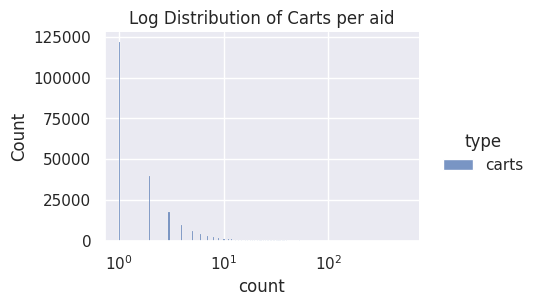

In [31]:
(
    sns.displot(
        data=n_per_aid.loc[n_per_aid["type"]=="carts"], 
        x='count',
        hue='type',
        log_scale=True,
        multiple='dodge',
        height=3, 
        aspect=1.5,
    )
    .set(
        title='Log Distribution of Carts per aid',
    )
)

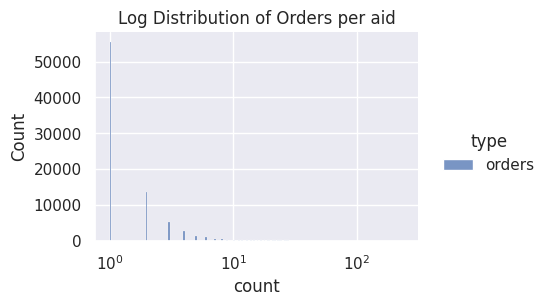

In [32]:
(
    sns.displot(
        data=n_per_aid.loc[n_per_aid["type"]=="orders"], 
        x='count',
        hue='type',
        log_scale=True,
        multiple='dodge',
        height=3, 
        aspect=1.5,
    )
    .set(
        title='Log Distribution of Orders per aid',
    )
)

**Findings**:
1. Clicks per `aid`: About 75% of the articles are clicked on 1 to 5 times. This means that most items are clicked on pretty uniformly.
2. Carts per `aid`, and orders per `aid`: About 90% of articles that are added to card or ordered are done so 1 to 3 times. This is also a pretty uniform distribution.
3. Conversion rate: The percentage of items that are clicked on and added to cart is about 25%. The percentage of items clicked on and ordered is about 10%. The conversion rate from carts to orders is about 40%.

### Co-occurence Matrix

Aka Co-Visitation Matrix

Approach:
1. `sample_train_df` has two columns,`session` and `events`. `session` contains the session ID, and `events` contains a list of dictionaries. One of the key in the dictionary is the article ID.
2. We will concatenate all the article IDs into a string for each session.
3. Then we will use the CountVectorizer from sklearn to obtain a sparse matrix containing the counts of each article ID in each document. Let's call this matrix X.
4. The dot product of X transpose and X gives us the **article-article co-occurrence matrix**.  

In [33]:
sample_train_df.head(3)

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."


In [34]:
# Example
" ".join([f"{y['aid']}" for y in sample_train_df.loc[1,'events']])

'424964 1492293 1492293 910862 910862 1491172 1491172 424964 1515526 440486 109488 1507622 1734061 854637 854637 718983 215311 215311 718983 711125 711125 50049 105393 105393 959544 1734061 1842593 1464360 207905 1628317 376932 497868'

In [35]:
article_string_df = pd.DataFrame(
    {
        'session': sample_train_df['session'], 
        'article_string': sample_train_df['events'].transform(lambda x: " ".join([f"{y['aid']}" for y in x]))
    }
)

article_string_df.head(3)

,session,article_string
0,0,1517085 1563459 1309446 16246 1781822 1152674 ...
1,1,424964 1492293 1492293 910862 910862 1491172 1...
2,2,763743 137492 504789 137492 795863 378348 7958...


In [36]:
aid_dict = (
    expanded_df[['aid']]
    .drop_duplicates()
    .astype(str)
    .reset_index(drop=True)
    .to_dict()
    ['aid']
)

In [37]:
# Create the vocabulary dictionary
vocabulary = {v: k for k, v in aid_dict.items()}

vectorizer = CountVectorizer(vocabulary=vocabulary)

X = vectorizer.fit_transform(article_string_df['article_string'])
X

<150000x830140 sparse matrix of type '<class 'numpy.int64'>'
	with 4515797 stored elements in Compressed Sparse Row format>

In [38]:
print(vectorizer.get_feature_names_out().shape)
vectorizer.get_feature_names_out()

(830140,)


array(['1517085', '1563459', '1309446', ..., '891341', '1411609',
       '1154833'], dtype=object)

In [39]:
X[X > 0] = 1 # to avoid spurious co-occurences. See Reference #4.
co_matrix = (X.T * X)
co_matrix.setdiag(0) # diagonals don't hold anything meaningful related to co-occurence

In [40]:
co_matrix

<830140x830140 sparse matrix of type '<class 'numpy.int64'>'
	with 361631310 stored elements in Compressed Sparse Column format>

In [41]:
co_matrix.shape, co_matrix.size

((830140, 830140), 361631310)

In [42]:
# Keeping only the upper triangle since co-occurence matrices are symmetrical
upper = triu(co_matrix)

In [43]:
del co_matrix

In [44]:
x = upper.count_nonzero()
y = upper.size
print(f"% of non-zero co-occurence:{x/y:%}")
print(f"Total non-zero values: {upper.size:,}")
print(f"% sparse:{1 - upper.size/(upper.shape[0]*upper.shape[1]):%}")
print(f"Maximum co-occurence:{upper.max()}")
print(f"Total co-occurence:{upper.sum():,}")
print(f"Average co-occurence for non-zero values:{upper.sum()/upper.size:2f}")

% of non-zero co-occurence:99.839476%
Total non-zero values: 181,230,725
% sparse:99.973702%
Maximum co-occurence:677
Total co-occurence:200,239,317
Average co-occurence for non-zero values:1.104886


In [45]:
upper.eliminate_zeros()

In [46]:
values = upper.data

In [47]:
len(values)

180939806

In [48]:
print(f"% of values that are equal to 1: {len(values[values==1])/len(values):%}")
print(f"% of values that are <= 2: {len(values[values<=2])/len(values):%}")
print(f"% of values that are <= 3: {len(values[values<=3])/len(values):%}")

% of values that are equal to 1: 94.754666%
% of values that are <= 2: 98.248106%
% of values that are <= 3: 99.094613%


**Findings**
1. The co-occurrence matrix of shape (830,140, 830,140) is 99.97% is sparse, i.e. almost all the values are 0. This is not unexpected in co-oocurrence matrices. This is due to a large vocabulary size, of 830k+ article IDs.
2. Out of all the non-zero values ~95% are equal to 1, and 99% are less than or equal to 3. This means there is not a very strong co-occurence. One caveat is that our sample size of 150K is only about 1% of the entire dataset.
3. The maximum co-ccurence is 677.

### Co-Visitation Matrix (Approach 2)

Based on Sources 5 and 6.

In [49]:
!kaggle datasets download theoviel/otto-dataset

Dataset URL: https://www.kaggle.com/datasets/theoviel/otto-dataset
License(s): CC0-1.0
 99%|██████████████████████████████████████▋| 1.31G/1.32G [00:10<00:00, 170MB/s]
100%|███████████████████████████████████████| 1.32G/1.32G [00:10<00:00, 139MB/s]


In [50]:
!unzip otto-dataset.zip

Archive:  otto-dataset.zip
  inflating: train_parquet/000.parquet  
  inflating: train_parquet/001.parquet  
  inflating: train_parquet/002.parquet  
  inflating: train_parquet/003.parquet  
  inflating: train_parquet/004.parquet  
  inflating: train_parquet/005.parquet  
  inflating: train_parquet/006.parquet  
  inflating: train_parquet/007.parquet  
  inflating: train_parquet/008.parquet  
  inflating: train_parquet/009.parquet  
  inflating: train_parquet/010.parquet  
  inflating: train_parquet/011.parquet  
  inflating: train_parquet/012.parquet  
  inflating: train_parquet/013.parquet  
  inflating: train_parquet/014.parquet  
  inflating: train_parquet/015.parquet  
  inflating: train_parquet/016.parquet  
  inflating: train_parquet/017.parquet  
  inflating: train_parquet/018.parquet  
  inflating: train_parquet/019.parquet  
  inflating: train_parquet/020.parquet  
  inflating: train_parquet/021.parquet  
  inflating: train_parquet/022.parquet  
  inflating: train_parquet/023

In [51]:
import glob
import gc
from tqdm.notebook import tqdm

train_files = sorted(glob.glob("train_parquet/*"))[:10]

In [52]:
train_files

['train_parquet/000.parquet',
 'train_parquet/001.parquet',
 'train_parquet/002.parquet',
 'train_parquet/003.parquet',
 'train_parquet/004.parquet',
 'train_parquet/005.parquet',
 'train_parquet/006.parquet',
 'train_parquet/007.parquet',
 'train_parquet/008.parquet',
 'train_parquet/009.parquet']

In [53]:
PARTS = 2
SIZE = 1.86e6 / PARTS  # 1.86e6 si the maximum item ID
N_CANDIDS = 20

In [54]:
SIZE*10

9300000.0

In [55]:
covisitation_matrix = []

for part in range(PARTS):
    print(f"- Part {part + 1}/{PARTS}")
    matrix = None
    for file_idx, file in enumerate(tqdm(train_files)):
        # Load sessions & convert columns to save memory
        df = pd.read_parquet(file, columns=["session", "aid", "ts"])
        df["ts"] = (df["ts"] / 1000).astype("int32")
        df[["session", "aid"]] = df[["session", "aid"]].astype("int32")

        # Restrict to first 30 interactions
        df = df.sort_values(
            ["session", "ts"], ascending=[True, False], ignore_index=True
        )
        df["n"] = df.groupby("session").cumcount()
        df = df.loc[df.n < 30].drop("n", axis=1)

        # Compute pairs
        df = df.merge(df, on="session")

        # Split in parts to reduce memory usage
        df = df.loc[(df["aid_x"] >= part * SIZE) & (df["aid_x"] < (part + 1) * SIZE)]

        # Restrict to <1h and remove self-matches
        df = df.loc[
            ((df["ts_x"] - df["ts_y"]).abs() < 60 * 60) & (df.aid_x != df.aid_y)
        ]

        # No duplicated interactions within sessions
        df = df.drop_duplicates(
            subset=["session", "aid_x", "aid_y"],
            keep="first",
        ).reset_index(drop=True)

        # Compute weights of pairs
        df["wgt"] = 1
        df["wgt"] = df["wgt"].astype("float32")

        df.drop(["session", "ts_x", "ts_y"], axis=1, inplace=True)
        df = df.groupby(["aid_x", "aid_y"]).sum()

        # Update covisitation matrix with new weights
        if matrix is None:
            matrix = df
        else:
            matrix = matrix.add(df, fill_value=0)  # this is the bottleneck operation

        # Clear memory
        del df
        gc.collect()

    # Final matrix : Sort values
    matrix = matrix.reset_index().rename(columns={"aid_x": "aid", "aid_y": "candidate"})
    matrix = matrix.sort_values(
        ["aid", "wgt"], ascending=[True, False], ignore_index=True
    )

    # Restrict to n candids
    matrix["rank"] = matrix.groupby("aid").candidate.cumcount()
    matrix = matrix[matrix["rank"] < N_CANDIDS].reset_index(drop=True)
    covisitation_matrix.append(matrix)

covisitation_matrix = pd.concat(covisitation_matrix, ignore_index=True)

- Part 1/2


  0%|          | 0/10 [00:00<?, ?it/s]

- Part 2/2


  0%|          | 0/10 [00:00<?, ?it/s]

In [56]:
covisitation_matrix

,aid,candidate,wgt,rank
0,0,643097,2.0,0
1,0,994505,2.0,1
2,0,29217,1.0,2
3,0,150507,1.0,3
4,0,320565,1.0,4
...,...,...,...,...
14303129,1855602,1119153,1.0,15
14303130,1855602,1219756,1.0,16
14303131,1855602,1238883,1.0,17
14303132,1855602,1264423,1.0,18


In [57]:
(covisitation_matrix["wgt"]==1).sum()/covisitation_matrix.shape[0]

0.8371891782598135

In [58]:
print(f"% of values that are equal to 1: {(covisitation_matrix['wgt']==1).sum()/covisitation_matrix.shape[0]:%}")
print(f"% of values that are <= 2: {(covisitation_matrix['wgt']<=2).sum()/covisitation_matrix.shape[0]:%}")
print(f"% of values that are <= 3: {(covisitation_matrix['wgt']<=3).sum()/covisitation_matrix.shape[0]:%}")

% of values that are equal to 1: 83.718918%
% of values that are <= 2: 92.303617%
% of values that are <= 3: 95.224977%
